# Investigate Berlin House Prices

## Table of Contents
<ul>
<li><a href="#introduction">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a>
    <ul>
        <li><a href="#gather">Gather</a></li>
        <li><a href="#assess">Assess</a></li>
        <li><a href="#clean">Clean</a></li>
    </ul>
</li>
<li><a href="#feature_engineering">Feature Engineering</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#ml">Model Training</a></li>
</ul>

<a id='introduction'></a>
## Introduction

**What well can we predict the population of a given place based solely on the mapping features of the area?**

The present workflow is an exploration and a base case solution for the problem of finding a model;

In [1]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

<a id='wrangling'></a>
## Data Wrangling

<a id='gather'></a>
### Gather

In [2]:
datasets_dir = '../data/kontur-tiles-pop'

df = None
for filename in os.listdir(datasets_dir):
    file_path = os.path.join(datasets_dir, filename)
    if df is not None:
        df = pd.concat([df, gpd.read_file(file_path)]) 
    else:
        df = gpd.read_file(file_path)

In [3]:
countries = gpd.read_file('../data/countries.geojson')

In [4]:
world = gpd.read_file('../data/world.geojson')

<a id='assess'></a>
### Assess

In [5]:
countries.head()

,ADMIN,ISO_A3,geometry
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993..."


In [6]:
world.head()

,id,geometry
0,0,"MULTIPOLYGON (((-147.071 -76.076, -146.908 -76..."


In [7]:
df.head()

,count,building_count,highway_length,osm_users,population,gdp,avg_ts,max_ts,p90_ts,area_km2,local_hours,total_hours,one,geometry
0,0,0,0.0,0,14,5.710252e+05,0.0,0,0.0,0.680845,0,0,1,"POLYGON ((-4.34887 52.96012, -4.34286 52.95702..."
1,0,0,0.0,0,25,1.019688e+06,0.0,0,0.0,0.683204,0,0,1,"POLYGON ((-4.53117 52.85846, -4.52517 52.85535..."
2,0,0,0.0,0,43,1.753863e+06,0.0,0,0.0,0.678652,0,0,1,"POLYGON ((-4.42852 53.22094, -4.42251 53.21775..."
3,0,0,0.0,0,5,2.039376e+05,0.0,0,0.0,0.678562,0,0,1,"POLYGON ((-4.43882 53.23615, -4.43281 53.23296..."
4,0,0,0.0,0,91,3.711664e+06,0.0,0,0.0,0.680726,0,0,1,"POLYGON ((-4.34097 52.96601, -4.33479 52.96291..."


In [8]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 279619 entries, 0 to 5113
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   count           279619 non-null  int64   
 1   building_count  279619 non-null  int64   
 2   highway_length  279619 non-null  float64 
 3   osm_users       279619 non-null  int64   
 4   population      279619 non-null  int64   
 5   gdp             279619 non-null  float64 
 6   avg_ts          279619 non-null  float64 
 7   max_ts          279619 non-null  int64   
 8   p90_ts          279619 non-null  float64 
 9   area_km2        279619 non-null  float64 
 10  local_hours     279619 non-null  int64   
 11  total_hours     279619 non-null  int64   
 12  one             279619 non-null  int64   
 13  geometry        279619 non-null  geometry
dtypes: float64(5), geometry(1), int64(8)
memory usage: 32.0 MB


In [10]:
df.describe()

,count,building_count,highway_length,osm_users,population,gdp,avg_ts,max_ts,p90_ts,area_km2,local_hours,total_hours,one,pop_density
count,279619.000000,279619.000000,279619.000000,279619.000000,279619.000000,2.796190e+05,2.796190e+05,2.796190e+05,2.796190e+05,279619.000000,279619.000000,279619.000000,279619.0,279619.000000
mean,74.683991,32.276830,3148.685399,6.690393,221.928195,9.004360e+06,1.445537e+09,1.534349e+09,1.508732e+09,0.662468,1.767158,3.998237,1.0,335.036284
std,219.702942,137.065492,3901.016378,7.578730,740.109672,3.013653e+07,1.090520e+08,1.138238e+08,1.150843e+08,0.017398,5.601085,8.333091,0.0,1117.378143
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.604437,0.000000,0.000000,1.0,0.000000
25%,6.000000,0.000000,409.871571,2.000000,0.000000,0.000000e+00,1.409795e+09,1.522703e+09,1.482095e+09,0.649041,0.000000,0.000000,1.0,0.000000
50%,17.000000,0.000000,1884.812683,4.000000,6.000000,2.447251e+05,1.452918e+09,1.567591e+09,1.538874e+09,0.658685,0.000000,2.000000,1.0,9.208102
75%,50.000000,7.000000,4262.996547,8.000000,59.000000,2.400893e+06,1.496607e+09,1.581340e+09,1.566293e+09,0.674298,2.000000,4.000000,1.0,89.249872
max,8183.000000,4998.000000,40226.163919,226.000000,16302.000000,6.649181e+08,1.587138e+09,1.587153e+09,1.587153e+09,0.718782,357.000000,434.000000,1.0,24620.326251


In [11]:
df["area_km2"].sum()

185238.70913546925

In [12]:
df["population"].sum()

62055340

In [13]:
df["highway_length"].sum()

880432262.4853239

In [164]:
df.index.nunique()

214725

In [14]:
df["gdp"].sum()

2517790217552.565

In [15]:
gb = df["geometry"].intersection(countries[countries["ISO_A3"] == "GBR"]["geometry"])

In [17]:
inter = gpd.overlay(df, countries[countries["ISO_A3"] == "GBR"], how='intersection')

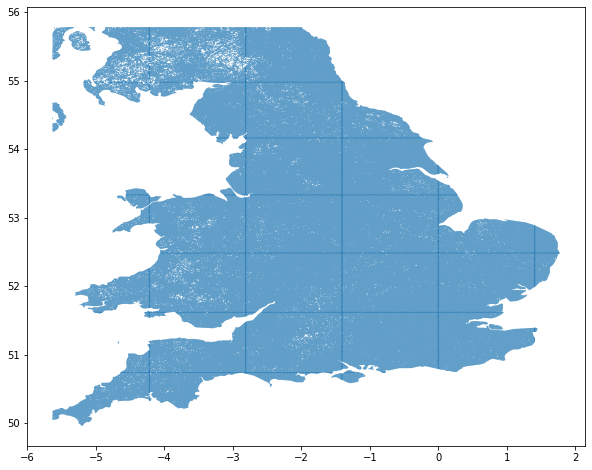

In [45]:
inter.plot(figsize=(10, 10))

In [40]:
inter.describe()

,count,building_count,highway_length,osm_users,population,gdp,avg_ts,max_ts,p90_ts,area_km2,local_hours,total_hours,one,pop_density
count,252232.000000,252232.000000,252232.000000,252232.000000,252232.000000,2.522320e+05,2.522320e+05,2.522320e+05,2.522320e+05,252232.000000,252232.000000,252232.000000,252232.0,252232.000000
mean,72.725114,28.436289,3247.701822,6.890922,236.241892,9.589686e+06,1.446867e+09,1.535555e+09,1.511729e+09,0.663555,1.881605,4.171164,1.0,356.388849
std,210.217627,125.611233,3977.802817,7.759947,772.113158,3.143952e+07,1.118281e+08,1.163406e+08,1.172407e+08,0.017439,5.824365,8.606062,0.0,1165.470645
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.633148,0.000000,0.000000,1.0,0.000000
25%,7.000000,0.000000,462.432056,2.000000,0.000000,0.000000e+00,1.412913e+09,1.525383e+09,1.486755e+09,0.649876,0.000000,1.000000,1.0,0.000000
50%,18.000000,0.000000,1956.309072,4.000000,6.000000,2.447251e+05,1.455262e+09,1.568147e+09,1.541706e+09,0.660141,0.000000,2.000000,1.0,9.350125
75%,49.000000,6.000000,4392.515325,8.000000,59.000000,2.406463e+06,1.497050e+09,1.581515e+09,1.567049e+09,0.675762,2.000000,5.000000,1.0,89.446794
max,6132.000000,3352.000000,40226.163919,226.000000,16302.000000,6.649181e+08,1.587138e+09,1.587153e+09,1.587153e+09,0.718782,357.000000,434.000000,1.0,24620.326251


In [41]:
inter["area_km2"].sum()

167369.7357813916

In [42]:
inter["population"].sum()

59587765

In [43]:
inter["highway_length"].sum()

819174326.0772619

In [44]:
inter["gdp"].sum()

2418825721940.4873

In [73]:
inter[inter[["building_count", "highway_length", "population", "gdp", "avg_ts", "max_ts", "p90_ts", "area_km2"]].duplicated()]

In [93]:
def detect_outliers(df, column):
    
    Q1 = df[column].quantile(q=0.25)
    Q3 = df[column].quantile(q=0.75)

    IQR = Q3 - Q1

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR
    
    return df[(df[column] > max_value) | (df[column] < min_value)]


inter["outlier_detection"] = inter["population"] / inter["highway_length"] / inter["building_count"]

detect_outliers(inter, 'outlier_detection')

,count,building_count,highway_length,osm_users,population,gdp,avg_ts,max_ts,p90_ts,area_km2,local_hours,total_hours,one,pop_density,ADMIN,ISO_A3,geometry,outlier_detection
0,0,0,0.000000,0,14,5.710252e+05,0.000000e+00,0,0.000000e+00,0.680845,0,0,1,20.562689,United Kingdom,GBR,"POLYGON ((-4.34887 52.96012, -4.34286 52.95702...",inf
1,0,0,0.000000,0,25,1.019688e+06,0.000000e+00,0,0.000000e+00,0.683204,0,0,1,36.592311,United Kingdom,GBR,"POLYGON ((-4.53117 52.85846, -4.52517 52.85535...",inf
2,0,0,0.000000,0,43,1.753863e+06,0.000000e+00,0,0.000000e+00,0.678652,0,0,1,63.360889,United Kingdom,GBR,"POLYGON ((-4.42852 53.22094, -4.42251 53.21775...",inf
3,0,0,0.000000,0,5,2.039376e+05,0.000000e+00,0,0.000000e+00,0.678562,0,0,1,7.368522,United Kingdom,GBR,"POLYGON ((-4.43882 53.23615, -4.43281 53.23296...",inf
4,0,0,0.000000,0,91,3.711664e+06,0.000000e+00,0,0.000000e+00,0.680726,0,0,1,133.680778,United Kingdom,GBR,"POLYGON ((-4.34097 52.96601, -4.33479 52.96291...",inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252191,18,0,6435.969187,3,230,9.381128e+06,1.401085e+09,1585892011,1.500767e+09,0.704849,0,1,1,326.311006,United Kingdom,GBR,"POLYGON ((-4.46302 50.61484, -4.45719 50.61168...",inf
252193,17,0,17476.296512,11,133,5.424739e+06,1.416062e+09,1586343624,1.583802e+09,0.703734,0,6,1,188.991852,United Kingdom,GBR,"POLYGON ((-4.38166 50.66829, -4.37582 50.66513...",inf
252203,1,0,137.870907,1,92,3.752451e+06,1.572607e+09,1572607181,1.572607e+09,0.703780,0,1,1,130.722627,United Kingdom,GBR,"POLYGON ((-4.39899 50.67764, -4.39333 50.67460...",inf
252205,40,0,3712.566112,8,40,1.631501e+06,1.447293e+09,1586321968,1.523531e+09,0.704768,0,1,1,56.756230,United Kingdom,GBR,"POLYGON ((-4.45049 50.61320, -4.44466 50.61004...",inf


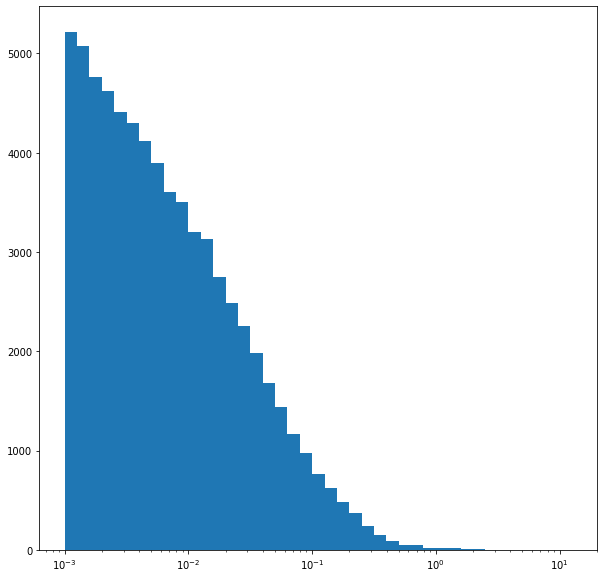

In [108]:
plt.figure(figsize=(10, 10))
bin_size = 0.1
bins = 10 ** np.arange(np.log10(0.001), np.log10(12) + bin_size, bin_size)

plt.hist(inter[inter['outlier_detection'] != np.inf]["outlier_detection"], bins=bins);
plt.xscale('log')

<a id='clean'></a>
### Clean

In [110]:
df = inter.copy()

Drop duplicated lines:

In [111]:
df.drop_duplicates(subset=["building_count", "highway_length", "population", "gdp", "avg_ts", "max_ts", "p90_ts", "area_km2"], inplace=True)

Drop unrequired columns:

In [112]:
df.drop(columns=['one', 'avg_ts', 'max_ts', 'p90_ts', 'local_hours', 'total_hours'], inplace=True)

Drop outliers:

In [114]:
df.drop(detect_outliers(inter, 'outlier_detection').index, axis=0, inplace=True)

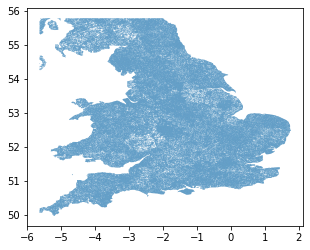

In [175]:
df.plot()

<a id='feature_engineering'></a>
## Feature Engineering

Calculate population density

In [115]:
df["pop_density"] = df["population"] / df["area_km2"]

Get squared osm_users

In [116]:
df["squared_osm_users"] = df["osm_users"] ** 2

<a id='eda'></a>
## Exploratory Data Analysis

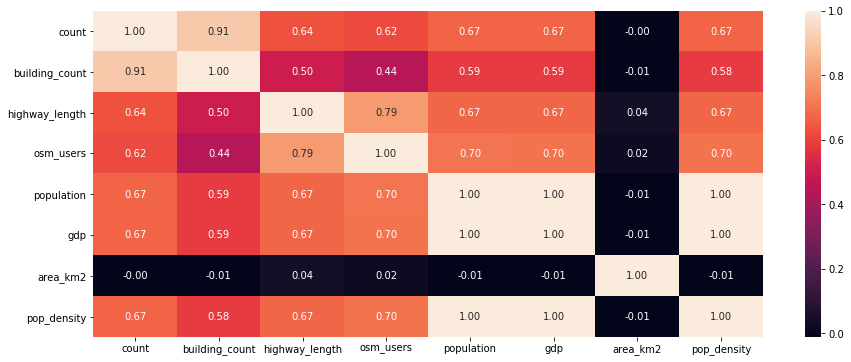

In [78]:
plt.figure(figsize=(15, 6))
sb.heatmap(df.corr(), annot=True, fmt=".2f");

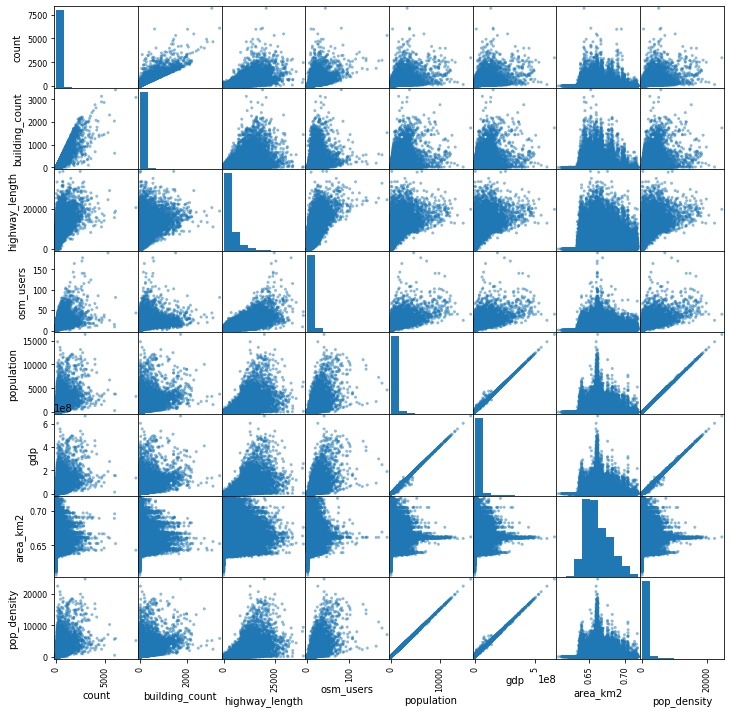

In [22]:
pd.plotting.scatter_matrix(df.sample(100000), figsize=(12, 12));

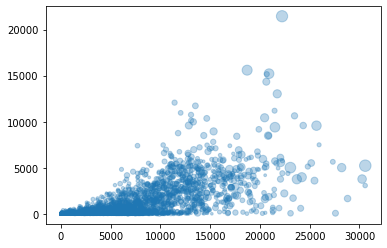

In [23]:
plt.scatter(data=df.sample(10000), x='highway_length', y='pop_density', s='osm_users', alpha=0.3);

In [25]:
df.describe()

,count,building_count,highway_length,osm_users,population,gdp,area_km2,pop_density
count,279619.000000,279619.000000,279619.000000,279619.000000,279619.000000,2.796190e+05,279619.000000,279619.000000
mean,74.683991,32.276830,3148.685399,6.690393,221.928195,9.004360e+06,0.662468,335.036284
std,219.702942,137.065492,3901.016378,7.578730,740.109672,3.013653e+07,0.017398,1117.378143
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.604437,0.000000
25%,6.000000,0.000000,409.871571,2.000000,0.000000,0.000000e+00,0.649041,0.000000
50%,17.000000,0.000000,1884.812683,4.000000,6.000000,2.447251e+05,0.658685,9.208102
75%,50.000000,7.000000,4262.996547,8.000000,59.000000,2.400893e+06,0.674298,89.249872
max,8183.000000,4998.000000,40226.163919,226.000000,16302.000000,6.649181e+08,0.718782,24620.326251


<a id='ml'></a>
## Model Training

In [117]:
df_model = df.copy()[['count', 'building_count', 'highway_length', 'osm_users', 'population']]

In [118]:
X = df_model[['count', 'building_count', 'highway_length', 'osm_users']]
y = df_model['population']

In [119]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [123]:
model = RandomForestRegressor(n_estimators=30)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [124]:
model.score(X_test, y_test)

0.6696802788410674

In [85]:
model.feature_importances_

array([0.17390356, 0.11395112, 0.57654277, 0.13560254])

In [88]:
def get_coef_df(df, model):
    coefs_df = pd.DataFrame()
    coefs_df['columns'] = [col.replace('_', ' ') for col in df.columns[:-1]]
    coefs_df['coefs'] = model.feature_importances_
    coefs_df['abs_coefs'] = np.abs(model.feature_importances_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

coefs_df = get_coef_df(df_model, model)
coefs_df.head(30)

,columns,coefs,abs_coefs
2,highway length,0.576543,0.576543
0,count,0.173904,0.173904
3,osm users,0.135603,0.135603
1,building count,0.113951,0.113951


In [34]:
cv = ShuffleSplit(n_splits=5, test_size=0.3)

scores = cross_val_score(model, X, y, cv=cv)
scores

array([0.63722143, 0.63236273, 0.63813606, 0.63969755, 0.63200849])

**Check for outliers**<br>
**Check input validity (gdp, etc) by comparing with total of england**

In [35]:
def plot_learning_curve(estimator, title, X, y, 
                        axes=None, ylim=None, cv=None,
                        n_jobs=-1, 
                        train_sizes=np.linspace(0.01, 1.0, 10)
#                         train_sizes=[5, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 185488]
                       ):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(8, 18))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Error")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, 
                       scoring='neg_mean_squared_error'
                      )
    
    train_scores = np.abs(train_scores)
    test_scores = np.abs(test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training error")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation error")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Error")
    axes[2].set_title("Performance of the model")

    return train_sizes, train_scores, test_scores, fit_times

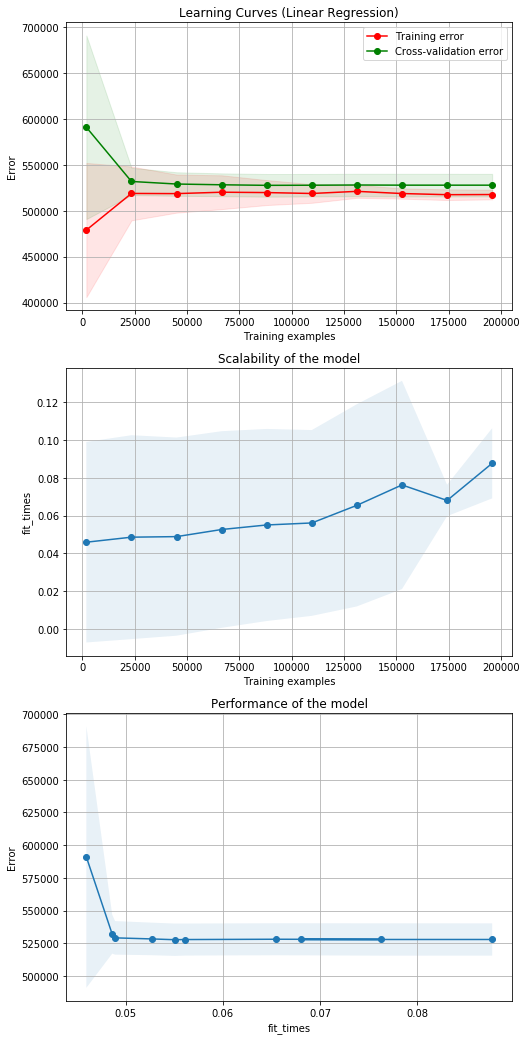

In [36]:
model = LinearRegression()

title = "Learning Curves (Linear Regression)"

cv = ShuffleSplit(n_splits=10, test_size=0.3)

train_sizes, train_scores, test_scores, fit_times = plot_learning_curve(model, title, X, y, cv=cv)

We can observe from the plots first plot above that using a Linear Regression model produces a model with a high bias, where more training examples doesn't lead to better performance. 

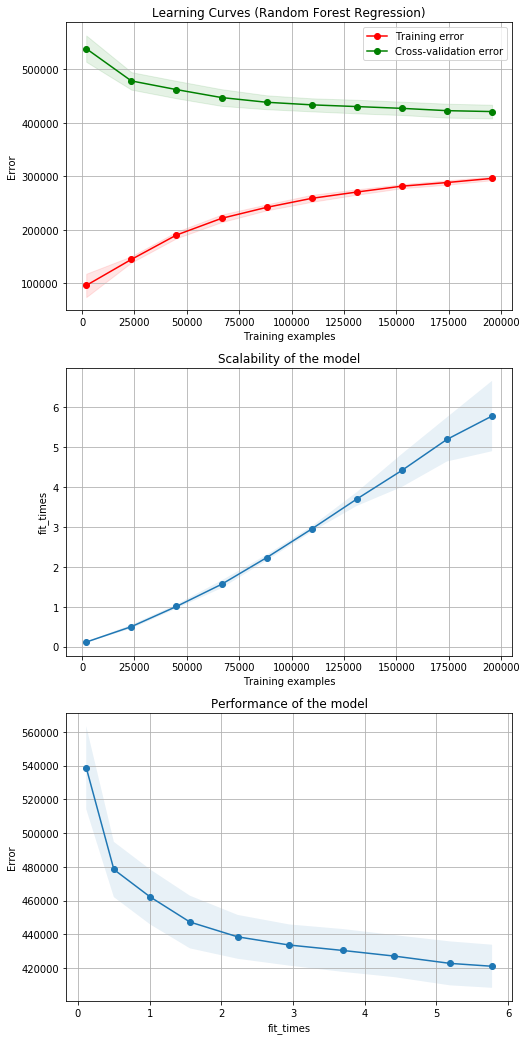

In [37]:
model = RandomForestRegressor(n_estimators=10, max_leaf_nodes=350)

title = "Learning Curves (Random Forest Regression)"

cv = ShuffleSplit(n_splits=10, test_size=0.3)

train_sizes, train_scores, test_scores, fit_times = plot_learning_curve(model, title, X, y, cv=cv)

Using a Random Forest regressor we switched to a high variance problem, where we are overfitting on the training data. The cross-validation error decreases with the increase in training examples, although with a slow rate.

In [38]:
np.sqrt(test_scores.mean(-1))

array([733.99758488, 691.67025137, 679.8202246 , 668.77502335,
       662.16250641, 658.49474843, 656.03860374, 653.4974834 ,
       650.18327605, 648.86878165])